In [8]:
#!unzip 'fra-eng.zip'
path_to_file = "/tf/img/text/fra.txt"

In [1]:
import unicodedata
import re
# Convert the unicode sequence to ascii
def unicode_to_ascii(s):
  # Normalize the unicode string and remove the non-spacking mark
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):
  # Clean the sequence
  w = unicode_to_ascii(w.lower().strip())
  # Create a space between word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
  # Add a start and stop token to detect the start and end of the sequence
  w = '<start> ' + w + ' <end>'
  return w

In [37]:
import pandas as pd
transD = pd.read_csv("/tf/img/text/eng-fra.csv.tar.gz")
for i in ['english','french']:
    transD[i] = transD[i].apply(lambda x: preprocess_sentence(x))
inp_lang, targ_lang = list(transD['english']), list(transD['french'])
transD.head()

,english,french
0,<start> go . <end>,<start> va ! <end>
1,<start> go . <end>,<start> marche . <end>
2,<start> go . <end>,<start> bouge ! <end>
3,<start> hi . <end>,<start> salut ! <end>
4,<start> hi . <end>,<start> salut . <end>


In [39]:
import tensorflow as tf
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer
input_tensor, inp_lang_token = tokenize(inp_lang)
target_tensor, targ_lang_token = tokenize(targ_lang)
num_examples = 50000
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [33]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

155610 155610 38903 38903


In [42]:
# Essential model parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_token.word_index) + 1
vocab_tar_size = len(targ_lang_token.word_index) + 1

In [43]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [44]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 54]), TensorShape([64, 65]))

In [46]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,return_sequences=True,
                                   return_state=True,recurrent_initializer='glorot_uniform')
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [47]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 54, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [48]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [49]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 54, 1)


In [50]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,return_sequences=True,
                                   return_state=True,recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

In [51]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),sample_hidden,sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 24323)


In [52]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [53]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [56]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_token.word_index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [57]:
import time
EPOCHS = 30
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4056
Epoch 1 Batch 100 Loss 0.8144
Epoch 1 Batch 200 Loss 0.7023
Epoch 1 Batch 300 Loss 0.7419
Epoch 1 Batch 400 Loss 0.5925
Epoch 1 Batch 500 Loss 0.5505
Epoch 1 Batch 600 Loss 0.5617
Epoch 1 Batch 700 Loss 0.5464
Epoch 1 Batch 800 Loss 0.4653
Epoch 1 Batch 900 Loss 0.4910
Epoch 1 Batch 1000 Loss 0.4896
Epoch 1 Batch 1100 Loss 0.5103
Epoch 1 Batch 1200 Loss 0.4795
Epoch 1 Batch 1300 Loss 0.4423
Epoch 1 Batch 1400 Loss 0.4494
Epoch 1 Batch 1500 Loss 0.3874
Epoch 1 Batch 1600 Loss 0.3915
Epoch 1 Batch 1700 Loss 0.3408
Epoch 1 Batch 1800 Loss 0.2877
Epoch 1 Batch 1900 Loss 0.2953
Epoch 1 Batch 2000 Loss 0.3432
Epoch 1 Batch 2100 Loss 0.2980
Epoch 1 Batch 2200 Loss 0.3057
Epoch 1 Batch 2300 Loss 0.2778
Epoch 1 Batch 2400 Loss 0.3189


KeyboardInterrupt: 

In [63]:
import numpy as np
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang_token.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang_token.word_index['<start>']], 0)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang_token.index_word[predicted_id] + ' '
    if targ_lang_token.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    dec_input = tf.expand_dims([predicted_id], 0)
  return result, sentence, attention_plot

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [64]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [65]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> what s the name of your sister ? <end>
Predicted translation: quelle est le nom de votre s ur ? <end> 


<ipython-input-59-6f7d9f6c0cde>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-59-6f7d9f6c0cde>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


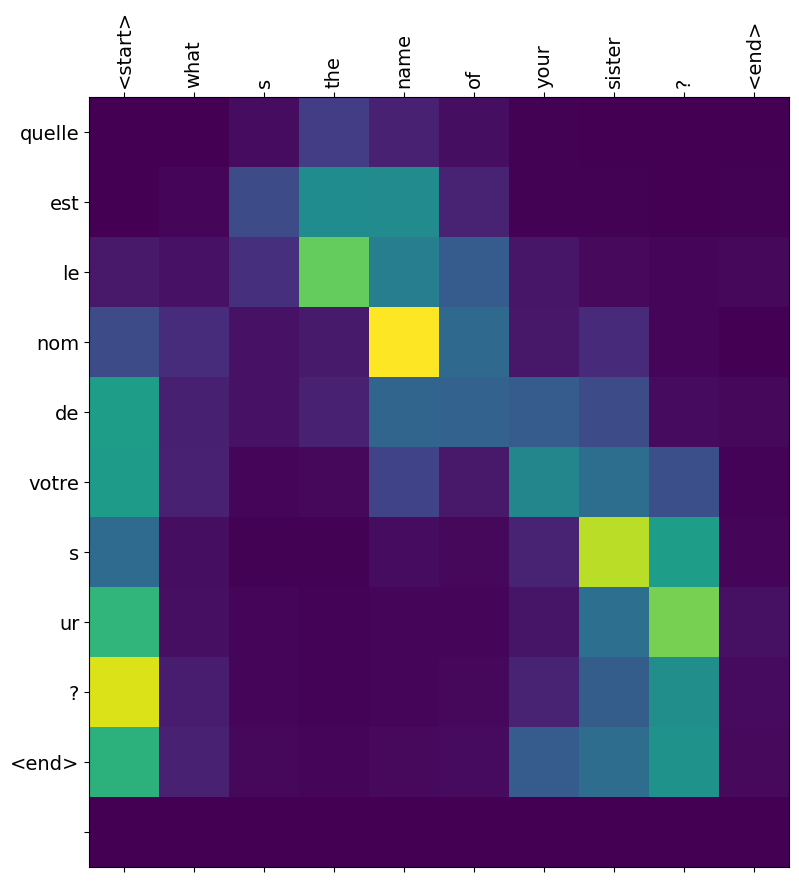

In [71]:
translate(u"What's the name of your sister?")